# Stanford Car Dataset Classification Task

In this project, we will build a Neural Network to solve the Car classification problem in the Stanford car dataset, available on https://ai.stanford.edu/~jkrause/cars/car_dataset.html \\ 

- The dataset is already split into train and test sets. 

- The dataset is prelabelled, and has predefined bounding boxes, so we will not need to train your model for object recognition. 

The first step would be to crop all images contained in both training and test sets using the predefining boxes, and to grayscale all the images.

We end up with a directory (cropped data) that contains two folds (Train and Test) and where we also created one directory containing all images included in a given class of image (i.e. Make, Model, Year).

The main constraint that we do have in this project is that we cannot use pre-trained Deep Convolutional Networks, this means that we restrain ourselves from using a Transfer Learning approach and we do have to train a whole NN from scratch. 

We achieve 80% accuracy on the test set



## Pre-processing:

In [75]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


an example of a picture in our dataset.

['anno_test.csv', 'anno_train.csv', 'car_data', 'names.csv']


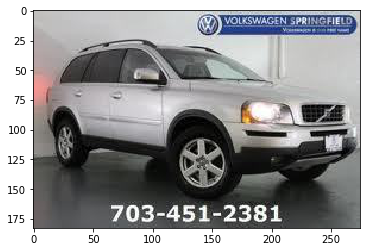

In [2]:
import cv2
%matplotlib inline
import pickle
from PIL import Image, ImageOps
import os
print(os.listdir("Stanford car dataset"))
path_base = 'Stanford car dataset'

image = Image.open(path_base + '/car_data/car_data/train/Volvo XC90 SUV 2007/00952.jpg')
imgplot = plt.imshow(image)
plt.show()

For now, let's create the directory cropped data where we save our cropped and grayscaled images.

In [ ]:
source_path= "Stanford car dataset/car_data/car_data"

end_path= "Cropped_data"

#For training images
train_path= source_path+"/train"
end_train_path= end_path+ "/train"

for model in os.listdir(train_path):
    
    
    for image_id in os.listdir(train_path+"/"+model):
        
        
        row_annot= annot_train[annot_train["image_id"]==image_id]
        
        x1= int(row_annot["x1"])
        y1= int(row_annot["y1"])
        x2= int(row_annot["x2"])
        y2= int(row_annot["y2"])
        bbox=(x1,y1,x2,y2)
        
        
        image_path= train_path+"/"+model+"/"+image_id
        
        img=Image.open(image_path)
        
        img=img.crop(bbox)
        
        img= ImageOps.grayscale(img)
        
        if not os.path.exists(end_train_path+"/"+model):
            os.makedirs(end_train_path+"/"+model)
        
        img.save(end_train_path+"/"+model+"/"+image_id) 
        
        
        
        
#For test images
test_path= source_path+"/test"
end_test_path= end_path+ "/test"

for model in os.listdir(test_path):
    
    
    for image_id in os.listdir(test_path+"/"+model):
        
        
        row_annot= annot_test[annot_test["image_id"]==image_id]
        
        x1= int(row_annot["x1"])
        y1= int(row_annot["y1"])
        x2= int(row_annot["x2"])
        y2= int(row_annot["y2"])
        bbox=(x1,y1,x2,y2)
        
        
        image_path= test_path+"/"+model+"/"+image_id
        
        img=Image.open(image_path)
        img=img.crop(bbox)
        
        img= ImageOps.grayscale(img)
        
        if not os.path.exists(end_test_path+"/"+model):
            os.makedirs(end_test_path+"/"+model)
        
        img.save(end_test_path+"/"+model+"/"+image_id) 
        


        

## Building the Neural Network (Test accuracy = 80%)

Before beginning the design of our NN, we used during loading data, many types of data augmentation (Resizing, Random Horizontal Flip, Random Rotation, Normalization) as done below.

In [77]:
dataset_dir ='/Cropped_data'

train_loader = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Extract dataset from its folder and buld train and test loaders
dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_loader)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_loader)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

## Neural Network class

We tried many configurations with CNN but many of our experimentations failed. We ended up stacking block of Residual Networks which we found out it works best (similar to https://arxiv.org/abs/1512.03385). Below we define the building blocks and the structure that we fine-tuned during the training (it gives a similar, yet different, architecture to ResNet34, but we build everything from scratch and train for our classification problem directly).

In [106]:
class ResBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [107]:
class NN(nn.Module):

    def __init__(self, block, layers, num_classes=196):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         

        x = self.layer1(x)          
        x = self.layer2(x)          
        x = self.layer3(x)          
        x = self.layer4(x)         

        x = self.avgpool(x)     # This part makes our model capable of handling any input size of images, as long as the dimension doesn't vanish with the the multiple convolutions     
        x = torch.flatten(x, 1)     
        x = self.fc(x)

        return x

Here we build training procedure, we found out that an SGD optimizer (with momentum) works better than Adam optimizer in this case. We also use a batch size of 32.

In [78]:
def train_model(model, criterion, optimizer, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

    

Below we define the test evaluation. To ensure we keep the best model at the end, we take a snapshot of the model that achieved the best accuracy so far during training epochs. This model is the one kept at the end.

In [118]:
best_test=0
def eval_model(model):
    global best_test
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total

    if test_acc> best_test:
      torch.save(model, "/content/drive/MyDrive/Project Classification Stanford dataset/best_model_final1.pt")

      best_test= test_acc


    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc


In [119]:
def NN_stack():
    layers=[3, 4, 6, 4]
    model = NN(ResBlock, layers)
    return model

In [120]:
model = NN_stack()

# replace the last fc layer with an untrained one (requires grad by default)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)



Below is the structure of our model

In [111]:
model

NN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (con

And then we begin the training procedure using our pre-defined train function

In [91]:
model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, n_epochs=50)

Epoch 1, duration: 162 s, loss: 5.3427, acc: 0.6177
Accuracy of the network on the test images: 0 %
Epoch 2, duration: 161 s, loss: 5.2077, acc: 1.1022
Accuracy of the network on the test images: 1 %
Epoch 3, duration: 161 s, loss: 5.1036, acc: 1.7684
Accuracy of the network on the test images: 1 %
Epoch 4, duration: 162 s, loss: 4.9329, acc: 2.0470
Accuracy of the network on the test images: 2 %
Epoch 5, duration: 162 s, loss: 4.6596, acc: 3.2946
Accuracy of the network on the test images: 3 %
Epoch 6, duration: 162 s, loss: 4.3565, acc: 5.4869
Accuracy of the network on the test images: 5 %
Epoch 7, duration: 162 s, loss: 4.0311, acc: 8.0911
Accuracy of the network on the test images: 9 %
Epoch 8, duration: 162 s, loss: 3.6811, acc: 12.6817
Accuracy of the network on the test images: 7 %
Epoch 9, duration: 162 s, loss: 3.2672, acc: 18.1202
Accuracy of the network on the test images: 11 %
Epoch 10, duration: 162 s, loss: 2.8349, acc: 26.3687
Accuracy of the network on the test images:

We then load the best model that we trained

In [115]:
model_final= torch.load("/content/drive/MyDrive/Project Classification Stanford dataset/best_model_final.pt")

We evaluate its performance on the test set

In [116]:
eval_model(model_final)

Accuracy of the network on the test images: 79 %


79.48016415868673

We also plot the evolution of training/test accuracies during the training (per epochs)

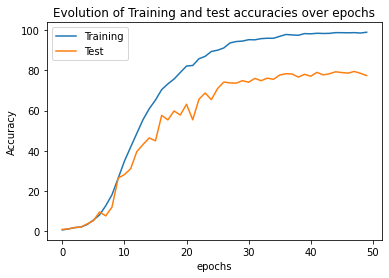

In [104]:
plt.figure()

plt.plot(training_accs, label="Training")
plt.plot(test_accs, label="Test")

plt.title("Evolution of Training and test accuracies over epochs")

plt.xlabel("epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [88]:
model_parameters = filter(lambda p: p.requires_grad, model_ft.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

26105860